# test crowd of mobile recordings
* Gather pilot testing responses
* align with the taps
* calculate instantaneous movement
* plot frame by frame of movement in fake audience grid (location map via colum title?)


In [17]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

Standard values and units

In [67]:
# conditions for comparison 246900 289766
units = 1000 # ms
fs = 20/units # 50 hz

# motion signal filtering: lowpass 0.5 Hz, 
cutoff = np.array([5])/units
nyq = 1 * fs 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

# key locations
data_loc = '/Users/finnu/Current_Projects/MusicLab_aligning/pilot_data/Mobile/'
metadata_loc = '/Users/finnu/Current_Projects/MusicLab_aligning/pilot_data/'
plot_loc = '/Users/finnu/Current_Projects/MusicLab_aligning/plots/'


In [68]:
# prep with copy of respy



In [69]:
os.chdir(metadata_loc)

trial_wise = pd.read_csv('trial_wise.csv')
trial_seq = pd.read_csv('Trial_Stim.csv')
trial_times=trial_seq.iloc[:,:2].copy()

trial_times['Time (ms)'] = units*trial_times['Time (s)']
trial_times=trial_times.set_index("Time (ms)", drop=True)
trial_wise.iloc[:5,:]

,filename,Data type,Resp start,Mobile start,Stim,Trial stim,Participant,Trial order,Mobile loc,Music Move,Move Act,Resp_file,Mobile_file,mocap_file
0,DS_T1_redo.qtm,Mocap,4.25,7.5,12,T1,DS,1,6,Standing,Clapping,1615819583587,data_part1_trial_1_Stim_T1.csv,DS_T1_redoLabeled2.tsv
1,DS_T3.qtm,Mocap,4.00,8.0,18,T3,DS,2,6,Seated,lean forward and back,1615820096915,data_part1_trial_2_Stim_T3.csv,DS_T3.tsv
2,DS_T5.qtm,Mocap,4.00,7.0,10,T5,DS,3,6,Seated,Text,1615820773283,data_part1_trial_3_Stim_T5.csv,DS_T5.tsv
3,DS_T7.qtm,Mocap,4.00,11.0,15,T7,DS,4,6,Seated,Stand stretch,1615821302122,data_part1_trial_4_Stim_T7.csv,DS_T7.tsv
4,DS_T2.qtm,Mocap,3.50,7.0,9,T2,DS,5,12,Standing,lean forward and back,1615822101240,data_part1_trial_5_Stim_T2.csv,DS_T2.tsv


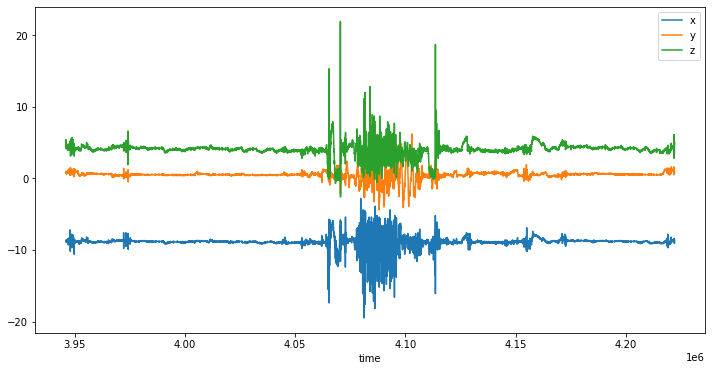

,timestamp,time,x,y,z,alpha,beta,gamma
0,1615819196237,3945994.1,-8.8,0.9,4.8,-12.7,1.0,-1.4
1,1615819196253,3946010.2,-8.9,0.7,5.4,-1.7,-3.6,-0.6
2,1615819196269,3946026.7,-8.7,0.7,4.3,2.7,-3.4,0.0
3,1615819196286,3946043.3,-8.7,0.7,4.3,2.7,-3.4,0.0
4,1615819196302,3946060.0,-8.7,0.9,4.2,-0.3,1.3,0.0
5,1615819196319,3946076.7,-8.7,1.0,4.2,-0.9,1.4,0.3
6,1615819196336,3946093.4,-8.7,0.9,4.3,-1.8,0.2,0.5
7,1615819196352,3946110.0,-8.7,0.8,4.4,-2.2,-0.6,0.4
8,1615819196369,3946126.7,-8.7,0.8,4.5,-1.3,-0.6,0.3
9,1615819196386,3946143.3,-8.8,0.8,4.4,-0.2,-0.1,0.7


In [300]:
# load the old mobile data for 82
os.chdir(data_loc)
rd = pd.read_csv('data_70_segment_6.csv')



fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)

cols = rd.columns
for c in cols[2:5]:
    rd.plot.line(x ='time', y = c,ax = ax)
plt.show()

rd.iloc[:10,:]

In [301]:
1000/rd['time'].diff().median()

59.8802395219599

In [302]:
# cut then filter
rd['Time (ms)'] = (rd['time']-rd['time'].loc[0])
time_new = np.arange(rd['Time (ms)'].iat[0],rd['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new.astype(int)
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000
cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']
for c in cols:
    f = interpolate.interp1d(rd['Time (ms)'], rd[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)-np.median(f(time_new))
    df_rs['dr ' + c] = respy.diffed(df_rs[c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs[c]))))
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))
mob_rs = df_rs.copy()


In [303]:
mob_rs

,Time (s),x,dr x,filt x,diff x,y,dr y,filt y,diff y,z,...,filt alpha,diff alpha,beta,dr beta,filt beta,diff beta,gamma,dr gamma,filt gamma,diff gamma
Time (ms),,,,,,,,,,,,,,,,,,,,,
0,0.00,0.064971,6.000000,1.029146e-11,8.922735,0.400000,-16.436382,6.336075e-11,-10.899775,0.700000,...,-2.009712e-09,79.352907,1.021087,-17.181361,1.617422e-10,-13.707438,-1.400000,15.044472,-2.217626e-10,18.802147
50,0.05,0.164971,2.000000,1.924900e-11,4.532607,0.209581,-0.091503,5.282532e-11,-4.648368,0.195210,...,-6.998356e-10,43.111801,-3.153763,-0.902874,-8.863210e-11,-4.794859,0.000000,7.699618,-5.645538e-11,13.182362
100,0.10,0.164971,-1.904192,2.236131e-11,1.947952,0.395783,2.065986,5.076180e-11,-1.218274,0.204217,...,-1.652253e-10,12.023589,0.187352,3.350590,-9.779519e-11,1.916081,0.495783,2.901379,5.076180e-11,7.393129
150,0.15,0.069761,2.000000,2.443618e-11,2.602464,0.304790,-2.182380,4.952330e-11,-3.072565,0.295210,...,-1.854207e-10,-2.901351,-0.059751,0.696664,1.508200e-11,3.476424,0.714371,0.809959,9.638583e-11,2.501093
200,0.20,0.264971,1.904192,2.929139e-11,3.628757,0.295210,-2.273884,4.243391e-11,-6.270354,0.209581,...,-2.893561e-10,-2.910726,0.830668,1.108217,9.037757e-11,1.690816,0.695210,-0.116736,1.024679e-10,-1.139711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275850,275.85,0.376416,2.000000,4.196048e-11,-1.148088,0.600000,-11.746233,7.430248e-11,-9.091179,-0.857229,...,-1.838645e-09,-16.228884,-3.398190,3.870611,-1.610175e-10,4.866977,0.281928,-7.027770,-6.016568e-11,-5.333863
275900,275.90,0.264971,-7.625365,3.639783e-11,-4.410502,0.058683,2.169935,6.317873e-11,-4.826802,0.576048,...,-1.728807e-09,28.924191,1.901926,6.713878,6.668608e-11,6.244947,-1.759880,-3.627562,-1.189747e-10,-1.535039
275950,275.95,-0.004852,3.409639,3.021579e-11,-6.823230,0.700000,3.707017,6.121990e-11,-3.614746,0.839645,...,-6.011585e-10,73.227891,2.801561,-2.727666,1.770106e-10,-0.135833,-0.611243,6.695025,-9.190018e-11,8.037547


(24.0, 30.0)

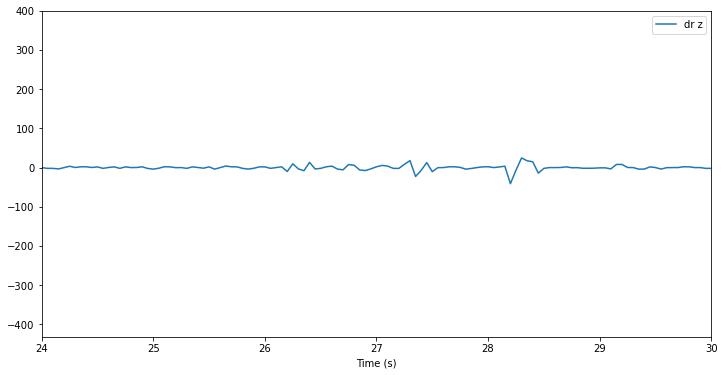

In [304]:
# pull out triple taps from z
t_range = [24,30]
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
mob_rs.plot.line(x ='Time (s)', y = 'dr z',ax = ax)
plt.xlim(t_range)


In [275]:
# template tap
tapz = mob_rs.loc[24000:30000,:]
print(tapz['dr z'].idxmax())
tapz.index = tapz.index -  tapz['dr z'].idxmax()
# zero on max (middle tap?)
print(tapz['dr z'].idxmax())
tapz_len_dur = tapz.index[-1] - tapz.index[0]
tapz_half_len = tapz_len_dur/2 #len(tapz)/2
print(tapz_half_len)
tapz_len_dur
tapz

27450
0
3000.0


,Time (s),x,dr x,filt x,diff x,y,dr y,filt y,diff y,z,...,filt alpha,diff alpha,beta,dr beta,filt beta,diff beta,gamma,dr gamma,filt gamma,diff gamma
Time (ms),,,,,,,,,,,,,,,,,,,,,
-3450,24.00,0.3,2.078947,4.375136e-11,2.584764,-0.100000,0.190476,-1.702073e-11,2.451423,0.372892,...,-1.942469e-11,-0.509157,0.194611,-5.003304e-01,8.043009e-12,-1.499607,0.000000,-0.666939,-4.066120e-12,-0.418149
-3400,24.05,0.3,0.000000,4.657826e-11,1.271839,-0.100000,-0.211735,-1.615933e-11,0.329564,0.372892,...,-1.983562e-11,1.260914,-0.210843,-5.630393e-01,-1.217743e-11,-1.307897,-0.100000,-0.071458,-5.433632e-12,0.568615
-3350,24.10,0.3,0.000000,4.653055e-11,-1.807100,-0.105357,-0.236670,-1.639553e-11,-0.131099,0.367534,...,2.097448e-11,4.372682,-0.058929,-6.913368e-01,-3.366572e-11,-1.389522,-0.010714,1.293942,2.049045e-12,2.337289
-3300,24.15,0.3,-2.184211,4.262943e-11,-3.969655,-0.105988,0.211735,-1.640803e-11,0.139788,0.478880,...,1.202633e-10,5.711859,-0.522156,-5.566279e-01,-5.648918e-11,-1.437347,0.094012,2.040327,1.970270e-11,3.379570
-3250,24.20,0.2,-2.054198,3.785616e-11,-2.130454,-0.100000,0.236670,-1.613035e-11,0.268080,0.472892,...,2.039800e-10,1.698696,-0.309581,-8.126484e-01,-7.950261e-11,-1.265180,0.295210,1.961357,3.839457e-11,2.178520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,29.80,0.1,-2.184211,1.089013e-11,-4.530585,-0.100000,0.000000,-1.584019e-11,0.000000,0.165706,...,2.015550e-11,-0.547259,0.607186,1.739116e-01,3.303758e-11,2.063535,0.192814,-0.048212,1.173958e-11,0.703173
2400,29.85,0.0,-2.184211,4.950059e-12,-4.077526,-0.100000,0.000000,-1.584019e-11,0.000000,0.072892,...,1.414472e-11,-0.227571,0.000000,3.960795e-01,5.437736e-11,0.637474,0.000000,-0.619016,1.166715e-11,-0.361767
2450,29.90,0.0,0.000000,1.980023e-12,-0.420503,-0.100000,0.000000,-1.584019e-11,0.000000,0.172892,...,1.286422e-11,-0.305296,0.785542,-4.930984e-16,5.336657e-11,-0.542671,0.100000,0.000000,7.848955e-12,-0.631200


In [333]:
# find the index of offset that 
signal = mob_rs.loc[:80000,'dr z']
signal_dur = signal.index[-1] - signal.index[0]

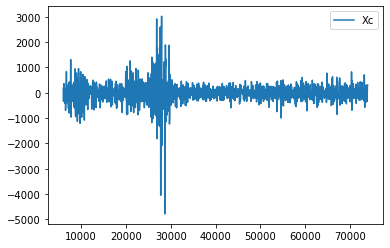

27950


In [334]:
#sync_cue = tapz['dr z']
shift_mids = range(tapz_len_dur,signal.index[-1]-tapz_len_dur,int(1/fs))
cross_orr = pd.DataFrame(index = shift_mids)
cross_orr['Xc'] = 0
cross_orr.dtypes

for i,row in cross_orr.iterrows():
    cross_orr.loc[i,'Xc'] = sync_cue.dot(signal.loc[i-tapz_half_len:i+tapz_half_len].values)
    
cross_orr.plot()
plt.show()
final_shift = cross_orr['Xc'].idxmax()
print(final_shift)

(-5000.0, 5000.0)

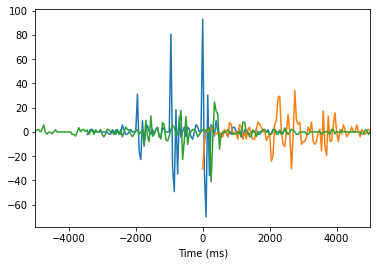

In [335]:
sync_cue.plot()
signal.plot()
signal.index = signal.index - final_shift# - 500 # I don't know why we are off by half a cycle hm
signal.plot()

plt.xlim([-5000,5000])